In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from hazm import Normalizer, stopwords_list, Lemmatizer, word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import resample
import joblib

In [2]:
normalizer = Normalizer()
lemmatizer = Lemmatizer()
stopwords = set(stopwords_list())

def preprocess_text(text):

    text = normalizer.normalize(str(text))
    tokens = word_tokenize(text)

    important_words = ['عالی','بسیار','خوب','خیلی','بهترین','نیست', 'نبود', 'ندار', 'نمی', 'نمیتوان', 'بدترین', 'افتضاح']
    processed_tokens = []

    for t in tokens:
        if t in important_words:
            processed_tokens.append(t)
        elif t not in stopwords and len(t) > 1:
            lemm = lemmatizer.lemmatize(t)
            processed_tokens.append(lemm)

    return " ".join(processed_tokens)

In [3]:
def load_data(path):

    df = pd.read_csv(path, sep='\t')
    df = df.dropna(subset=["comment", "label"])
    df["processed_text"] = df["comment"].apply(preprocess_text)
    return df


train_df = load_data("train.csv")
test_df = load_data("test.csv")
val_df = load_data("validation.csv")

In [4]:
print("Display The Number Of Samples:\n")

print(f"Number of training samples: {len(train_df)}")
print(f"Number of testing samples: {len(test_df)}")
print(f"Number of validation samples: {len(val_df)}")

print("\nBefore Data Balance:")

print(train_df['label'].value_counts())

Display The Number Of Samples:

Number of training samples: 400
Number of testing samples: 60
Number of validation samples: 60

Before Data Balance:
label
SAD      222
HAPPY    178
Name: count, dtype: int64


In [5]:
happy = train_df[train_df['label'] == 'HAPPY']
sad = train_df[train_df['label'] == 'SAD']

In [6]:
if len(happy) > len(sad):
    sad_balanced = resample(sad,replace=True,n_samples=len(happy),random_state=42) 
    train_df = pd.concat([happy, sad_balanced])
else:
    happy_balanced = resample(happy,replace=True,n_samples=len(sad),random_state=42)
    train_df = pd.concat([sad, happy_balanced])

train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [7]:
print("\nAfter Data Balance:")
print(train_df['label'].value_counts())


After Data Balance:
label
HAPPY    222
SAD      222
Name: count, dtype: int64


In [8]:
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
vectorizer.fit(train_df["processed_text"])

X_train = vectorizer.transform(train_df["processed_text"])
y_train = train_df["label"]

X_test = vectorizer.transform(test_df["processed_text"])
y_test = test_df["label"]

X_val = vectorizer.transform(val_df["processed_text"])
y_val = val_df["label"]

In [9]:
model = LinearSVC(C=0.5, class_weight='balanced')

In [10]:
model.fit(X_train, y_train)

,penalty,'l2'
,loss,'squared_hinge'
,dual,'auto'
,tol,0.0001
,C,0.5
,multi_class,'ovr'
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,verbose,0
,random_state,None


In [11]:
joblib.dump(model,'SnapSentiment.joblib')
joblib.dump(vectorizer,'vectorizer.joblib')

['vectorizer.joblib']

In [12]:
print("Saved.")

Saved.


In [13]:
print("Trained model")

Trained model


In [14]:
def predict_text(text):
    negative_patterns = ['نباید','نداشتم','نیومد','نیامد',' نبود', ' نیست', ' نداشت', 'دوست ندارم', 'بدترین', 'افتضاح']
    positive_patterns = ['دوست دارم','عالیه','خوبه','بهترین','لذت بردم','عاشقشم','عالی بود','خوشحال','راضی‌ام','جالب بود']

    text_normalized = normalizer.normalize(text)

    for pattern in negative_patterns:
        if pattern in text_normalized:
            return "SAD"

    for pattern in positive_patterns:
        if pattern in text_normalized:
            return "HAPPY"

    text_processed = preprocess_text(text)
    text_vec = vectorizer.transform([text_processed])
    return model.predict(text_vec)[0]

In [15]:
def evaluate_model(X, y, name):
    y_pred = model.predict(X)
    acc = accuracy_score(y, y_pred)
    print(f"\nAccuracy {name}: {acc:.3f}")
    print(classification_report(y, y_pred))
    return y_pred

In [16]:
y_test_pred = evaluate_model(X_test, y_test, "Test")


Accuracy Test: 0.850
              precision    recall  f1-score   support

       HAPPY       0.91      0.74      0.82        27
         SAD       0.82      0.94      0.87        33

    accuracy                           0.85        60
   macro avg       0.86      0.84      0.84        60
weighted avg       0.86      0.85      0.85        60



In [17]:
y_val_pred = evaluate_model(X_val, y_val, "Validation")


Accuracy Validation: 0.817
              precision    recall  f1-score   support

       HAPPY       0.95      0.64      0.77        28
         SAD       0.76      0.97      0.85        32

    accuracy                           0.82        60
   macro avg       0.85      0.81      0.81        60
weighted avg       0.85      0.82      0.81        60



Confusion Matrix:                                                                          : ماتریس سردرگمی

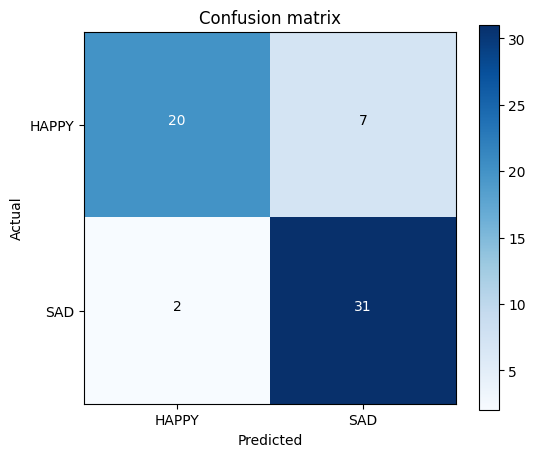

In [18]:
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6,5))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title("Confusion matrix")
plt.colorbar()

classes = sorted(set(y_test))
plt.xticks(range(len(classes)), classes)
plt.yticks(range(len(classes)), classes)

for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, cm[i, j], ha="center",color="white" if cm[i, j] > cm.max()/2 else "black")

plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

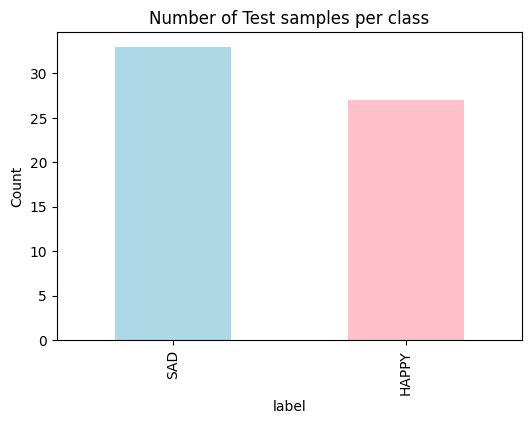

In [19]:
plt.figure(figsize=(6,4))
pd.Series(y_test).value_counts().plot(kind='bar', color=['lightblue', 'pink'])
plt.title('Number of Test samples per class')
plt.ylabel('Count')
plt.show()

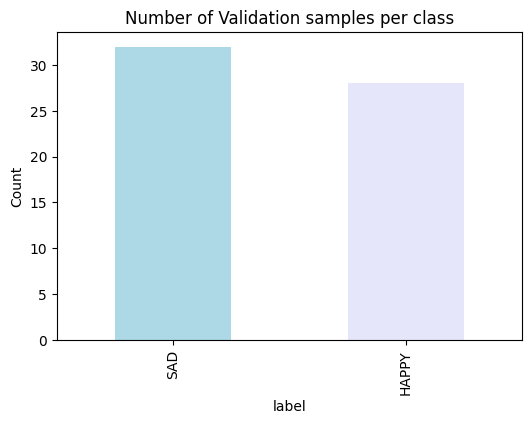

In [20]:
plt.figure(figsize=(6,4))
pd.Series(y_val).value_counts().plot(kind='bar', color=['lightblue', 'lavender'])
plt.title('Number of Validation samples per class')
plt.ylabel('Count')
plt.show()